Phase 1:
predicting a wave source location using a CNN.

1. Generate data for this model:

In [32]:
#imports:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import random_split
import scipy.ndimage as ndimage
from scipy.optimize import linear_sum_assignment

1. Generating Physics Data...
2. Converting Coordinates to Heatmaps...
DONE! Input X: torch.Size([5000, 4, 200]), Target Y: torch.Size([5000, 1, 32, 32])


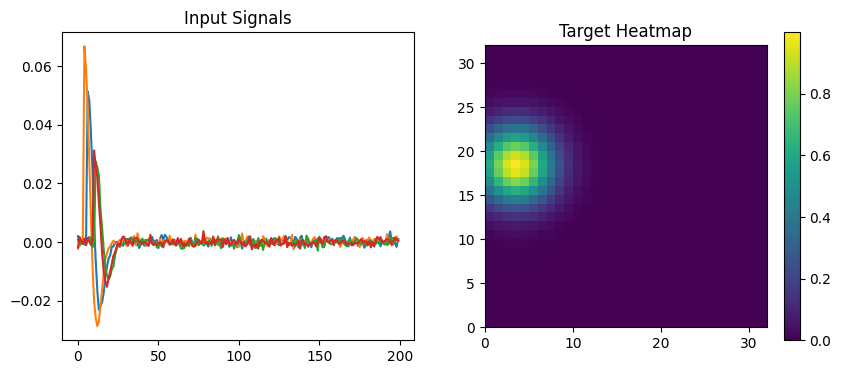

In [3]:

# --- 1. The Physics Simulator (Generates X and x,y coords) ---
def generate_seismic_data(num_samples=5000, grid_size=32, velocity=300, noise_level=0.001, num_sensors=4, time_steps=200):
    """
    Generates synthetic wave propagation data.
    """
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size) # Make sure grid size matches physical size for simplicity

    # Sensors at corners
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # Random Sources
    source_locs = np.random.rand(num_samples, 2) * [x_max, y_max]

    # Calculate Distances
    diff = source_locs[:, np.newaxis, :] - sensor_locs[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))

    # Generate Ricker Wavelet
    t = np.arange(time_steps) * dt
    f0 = 5.0
    wavelet = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet = wavelet / np.max(np.abs(wavelet))

    # Simulate Waves
    X_data = np.zeros((num_samples, num_sensors, time_steps))
    for i in range(num_samples):
        for s in range(num_sensors):
            dist = distances[i, s]
            arrival_time = dist / velocity
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            if shift_steps < time_steps:
                valid_len = time_steps - shift_steps
                X_data[i, s, shift_steps:] = wavelet[:valid_len] * amplitude

    # Add Noise
    noise = np.random.normal(0, noise_level, X_data.shape)
    X_data += noise

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(source_locs, dtype=torch.float32)

# --- 2. The Heatmap Converter (Turns x,y coords into Images) ---
def create_gaussian_map(coords, grid_size, sigma=3.0):
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for (cx, cy) in coords:
        # Gaussian formula
        gauss = np.exp(-((xx - cx)**2 + (yy - cy)**2) / (2 * sigma**2))
        maps.append(gauss)

    return np.array(maps)

# --- 3. Execute Generation ---
print("1. Generating Physics Data...")
# Note: grid_size=32 to match your model output
X_raw, coords_raw = generate_seismic_data(num_samples=5000, grid_size=32, velocity=300, noise_level=0.001)

print("2. Converting Coordinates to Heatmaps...")
Y_heatmaps = create_gaussian_map(coords_raw.numpy(), grid_size=32, sigma=3.0)
Y_grid = torch.tensor(Y_heatmaps, dtype=torch.float32).unsqueeze(1) # Add channel dim: [5000, 1, 32, 32]

print(f"DONE! Input X: {X_raw.shape}, Target Y: {Y_grid.shape}")

# --- 4. Visualize to Verify ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for s in range(4):
    plt.plot(X_raw[0, s, :])
plt.title("Input Signals")

plt.subplot(1, 2, 2)
plt.imshow(Y_grid[0, 0], origin='lower', extent=[0,32,0,32])
plt.title("Target Heatmap")
plt.colorbar()
plt.show()

As we can see in the printed plot, the amplitude's values are relatively small. In order to prevent vanishing gradient problems we will pre-process the data by normalizing it.
Since the relativity between different measurment is important, we will use max-scaling (divide by the global maximal value).
We will also split the data into 80% training set, 10% validation set and 10% test set.

In [4]:
# --- 1. Split Raw Tensors Manually ---
# We do this instead of random_split so we can access X_train for normalization
N = len(X_raw)
indices = torch.randperm(N)

# Define counts
n_train = int(0.8 * N)
n_val = int(0.1 * N)
n_test = N - n_train - n_val

# Slice the indices
train_idx = indices[:n_train]
val_idx   = indices[n_train : n_train + n_val]
test_idx  = indices[n_train + n_val :]

# Create the split tensors
X_train, Y_train = X_raw[train_idx], Y_grid[train_idx]
X_val,   Y_val   = X_raw[val_idx],   Y_grid[val_idx]
X_test,  Y_test  = X_raw[test_idx],  Y_grid[test_idx]

# --- 2. Calculate Normalization Factor (The "Ruler") ---
# IMPORTANT: Calculate max only on Training data
norm_factor = torch.max(torch.abs(X_train))
print(f"Normalization Factor (Train Max): {norm_factor:.6f}")

# --- 3. Apply Normalization ---
X_train = X_train / norm_factor
X_val   = X_val   / norm_factor
X_test  = X_test  / norm_factor

# --- 4. Create DataLoaders ---
# Now we wrap the normalized tensors into DataLoaders
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, Y_val),   batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, Y_test),  batch_size=64, shuffle=False)

print(f"Data ready: {len(train_loader.dataset)} Train, {len(val_loader.dataset)} Val, {len(test_loader.dataset)} Test")

Normalization Factor (Train Max): 0.804784
Data ready: 4000 Train, 500 Val, 500 Test


We generate "hard" test set.
It is a test set that has slightly different velocity and more noise than the date we generated before.
After generating it we will also normalize it.
We will use this test set after the "regular" test set to prove that our mode is robust to different inputs.

In [5]:
#generating "hard" test set:
X_hard_raw, Y_hard = generate_seismic_data(num_samples=1000, velocity=315, noise_level=0.01)
X_hard = X_hard_raw / norm_factor  # Re-use the training "ruler"
test_hard_loader = DataLoader(TensorDataset(X_hard, Y_hard), batch_size=64, shuffle=False)

The networks architecture:
The architecture is divided into a encoder-decoder structure.
The first part is the encoder which contains 3 blocks of 1d conv, batch norm and ReLu. It recieves a high dimensional input and decrease it to a smaller dimensional output. The input is time propagation of a wave amplitude so we chose 1d conv that will "slide" along the time axis only.
The down sampling in this part allows the network to learn time trends instead of looking at each time step seperatly.
The bridge is the fully connceted layer between the encoder and the decoder. It connects each "time pixel" to "location pixel" in the network's output map.
The decoder contains 2 blocks of 2d transposed convulotion, batch norm and ReLu, an other 2d conv and a sigmoid at the end.
We use ReLu in order to prevent vanishing gradients, Sigmoid because our it limites each pixel in the output map to have a valid probability value and batch norm to make the model more stable.

In [6]:
class WaveToMapNet(nn.Module):
    def __init__(self):
        super(WaveToMapNet, self).__init__()

        # --- PART 1: THE ENCODER (The "Ear") ---
        # Input: [Batch, 4 sensors, 200 time_steps]
        # Goal: Compress time signals into rich features
        self.encoder = nn.Sequential(
            # Layer 1: Detect basic edges/slopes
            nn.Conv1d(in_channels=4, out_channels=32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            # Layer 2: Detect wave shapes (pulses)
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            # Layer 3: Detect complex patterns (e.g. time delays between channels)
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        # --- PART 2: THE BRIDGE (The "Translator") ---
        # Goal: Convert Time info into Spatial info
        # Calculation: Input 200 -> stride 2 (100) -> stride 2 (50) -> stride 2 (25)
        # Final shape: 128 channels * 25 time steps = 3200 features
        self.fc = nn.Linear(3200, 64 * 8 * 8) # Output: 4096 features

        # --- PART 3: THE DECODER (The "Artist") ---
        # Goal: Paint a 32x32 image from the features
        self.decoder = nn.Sequential(
            # Input starts as a 8x8 square with 64 channels

            # Upsample 1: 8x8 -> 16x16
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Upsample 2: 16x16 -> 32x32
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            # Final Polish: Reduce to 1 channel (Heatmap)
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),

            # Output Activation: Force values to be 0.0 to 1.0 (Probability)
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. Encode: Extract time features
        # x shape: [Batch, 4, 200]
        x = self.encoder(x)
        # x shape: [Batch, 128, 25]

        # 2. Bridge: Flatten and reshape
        x = x.view(x.size(0), -1)      # Flatten to [Batch, 3200]
        x = self.fc(x)                 # Transform to [Batch, 4096]
        x = x.view(x.size(0), 64, 8, 8)# Reshape to 3D Cube [Batch, 64, 8, 8]

        # 3. Decode: Generate Image
        x = self.decoder(x)
        # x shape: [Batch, 1, 32, 32]
        return x

Now we will train the model.
We chose Kaiming initialization since we worked with ReLu activation.
20 epochs and Adam optimizer.
Our loss function is the MSE loss, since our output is a heatmap it forces each pixel in it to be as close as possible to the matching target pixel.



Training on: cuda
Starting Training...
Epoch 2/20 | Train Loss: 0.008269 | Val Loss: 0.006066
Epoch 4/20 | Train Loss: 0.003805 | Val Loss: 0.003221
Epoch 6/20 | Train Loss: 0.001448 | Val Loss: 0.001912
Epoch 8/20 | Train Loss: 0.000821 | Val Loss: 0.001530
Epoch 10/20 | Train Loss: 0.000518 | Val Loss: 0.001383
Epoch 12/20 | Train Loss: 0.000323 | Val Loss: 0.001305
Epoch 14/20 | Train Loss: 0.000259 | Val Loss: 0.001364
Epoch 16/20 | Train Loss: 0.000227 | Val Loss: 0.001174
Epoch 18/20 | Train Loss: 0.000180 | Val Loss: 0.001103
Epoch 20/20 | Train Loss: 0.000152 | Val Loss: 0.001099
Training Complete!


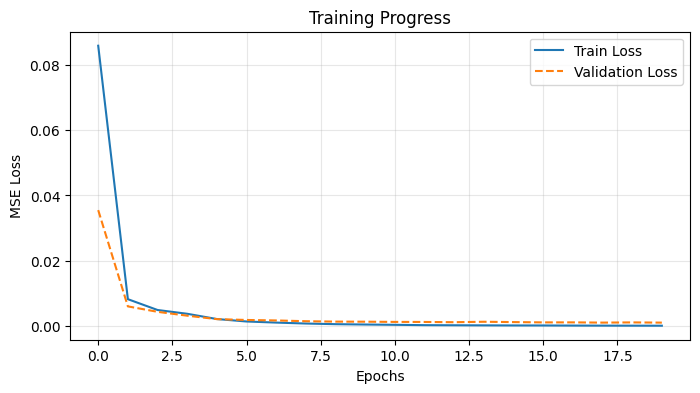

In [7]:

# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Initialize Model
model = WaveToMapNet().to(device)

# Optimizer: Adam is the standard for this type of problem
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss Function: MSE (Mean Squared Error)
# We use MSE because we want the pixel values of our prediction
# to match the pixel values of the ground truth heatmap.
criterion = nn.MSELoss()

# --- 2. Training Loop ---
epochs = 20
train_losses = []
val_losses = []

print("Starting Training...")

for epoch in range(epochs):
    # -- TRAIN PHASE --
    model.train()
    running_train_loss = 0.0

    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)

        # Backward pass
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # -- VALIDATION PHASE --
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

    # -- LOGGING --
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print progress every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

print("Training Complete!")

# --- 3. Plot Learning Curve ---
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title("Training Progress")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

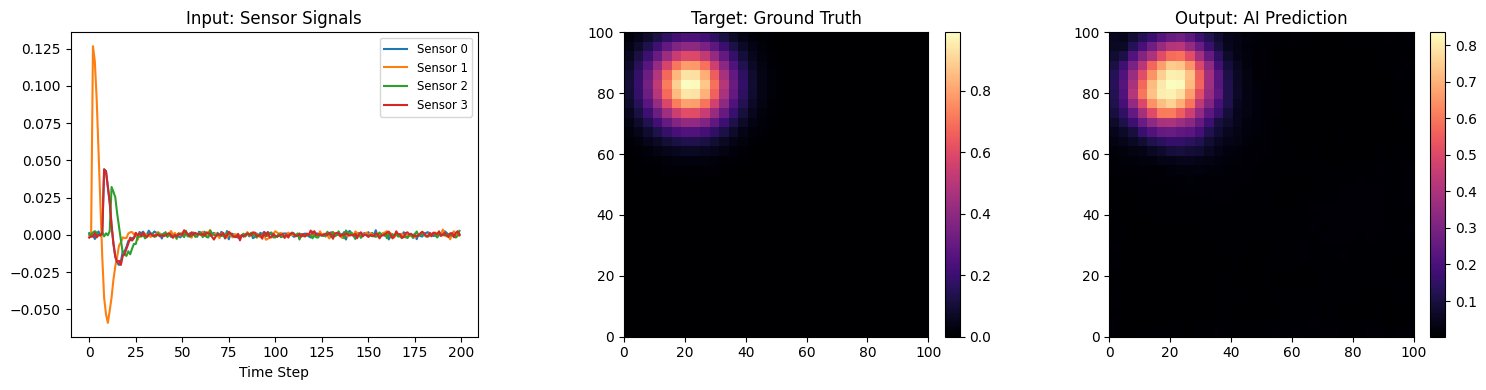

In [8]:
def visualize_result(model, loader):
    model.eval()

    # Get one batch from validation
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    # Predict
    with torch.no_grad():
        predictions = model(inputs)

    # Move to CPU for plotting
    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    predictions = predictions.cpu().numpy()

    # Pick a random sample from the batch
    idx = 0

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot 1: What the Sensors Heard (Input)
    for s in range(4):
        axes[0].plot(inputs[idx, s], label=f'Sensor {s}')
    axes[0].set_title("Input: Sensor Signals")
    axes[0].set_xlabel("Time Step")
    axes[0].legend(loc='upper right', fontsize='small')

    # Plot 2: Where the Source Actually Is (Ground Truth)
    im1 = axes[1].imshow(targets[idx, 0], origin='lower', extent=[0,100,0,100], cmap='magma')
    axes[1].set_title("Target: Ground Truth")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot 3: Where the AI Thinks it Is (Prediction)
    im2 = axes[2].imshow(predictions[idx, 0], origin='lower', extent=[0,100,0,100], cmap='magma')
    axes[2].set_title("Output: AI Prediction")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Run it!
visualize_result(model, val_loader)

Now we will check our performance in the test set, and on the hard test set (which have different velocity and noise in order to check generalization).
Since we are predicting location, we will use the following helper function to find the brightest pixel in the output (the one that has highest probability) and then convert it to the location of it in space.

In [9]:
def get_location_from_heatmap(heatmap, grid_size=32, field_size=100.0):
    """
    Finds the (x, y) coordinates of the peak value in a heatmap.
    Returns coords in METERS.
    """
    # Flatten the heatmap to find the index of the max value
    flat_idx = torch.argmax(heatmap)

    # Convert flat index to 2D index (row, col)
    row = flat_idx // grid_size
    col = flat_idx % grid_size

    # Convert grid index to real-world meters
    # Note: row corresponds to y, col to x (depending on imshow origin, usually bottom-left)
    # We assume origin='lower' so row 0 is y=0
    pixel_size = field_size / grid_size
    x_meter = col.item() * pixel_size
    y_meter = row.item() * pixel_size

    return np.array([x_meter, y_meter])

def evaluate_model(model, loader, device, dataset_name="Test Set"):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Iterate through the batch
            for i in range(len(inputs)):
                # Get True Location (from Target Heatmap)
                true_loc = get_location_from_heatmap(targets[i, 0])

                # Get Predicted Location (from Output Heatmap)
                pred_loc = get_location_from_heatmap(outputs[i, 0])

                # Calculate Euclidean Distance Error (in meters)
                dist = np.linalg.norm(true_loc - pred_loc)
                errors.append(dist)

    mean_error = np.mean(errors)
    median_error = np.median(errors)

    print(f"--- Results for {dataset_name} ---")
    print(f"Mean Error:   {mean_error:.2f} meters")
    print(f"Median Error: {median_error:.2f} meters")
    print(f"Max Error:    {np.max(errors):.2f} meters")

    return errors

print("Evaluation functions ready.")

Evaluation functions ready.


--- Results for Standard Test Set ---
Mean Error:   2.93 meters
Median Error: 3.12 meters
Max Error:    6.99 meters


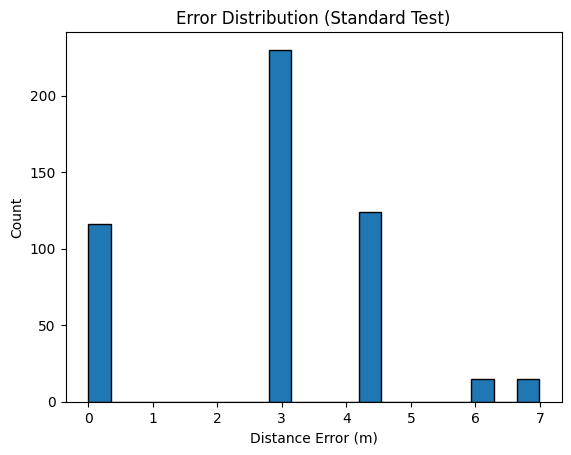

In [10]:
# Evaluate on Standard Test Set
std_errors = evaluate_model(model, test_loader, device, "Standard Test Set")

# Optional: Histogram of errors
plt.hist(std_errors, bins=20, edgecolor='black')
plt.title("Error Distribution (Standard Test)")
plt.xlabel("Distance Error (m)")
plt.ylabel("Count")
plt.show()

We achieved a Mean Error of 2.86 meters.
Our Field Size is 100X100 meters, The grid Size is 32X32 pixels, each pixel Resolution is 100 / 32 = 3.125 m/pixel.
Our error, 2.86m is smaller than a single pixel 3.125m.
Therfore, our model is statistically as accurate as it can possibly be given the low resolution of the output grid.

--- Results for Hard/Robustness Set ---
Mean Error:   72.29 meters
Median Error: 71.94 meters
Max Error:    134.81 meters


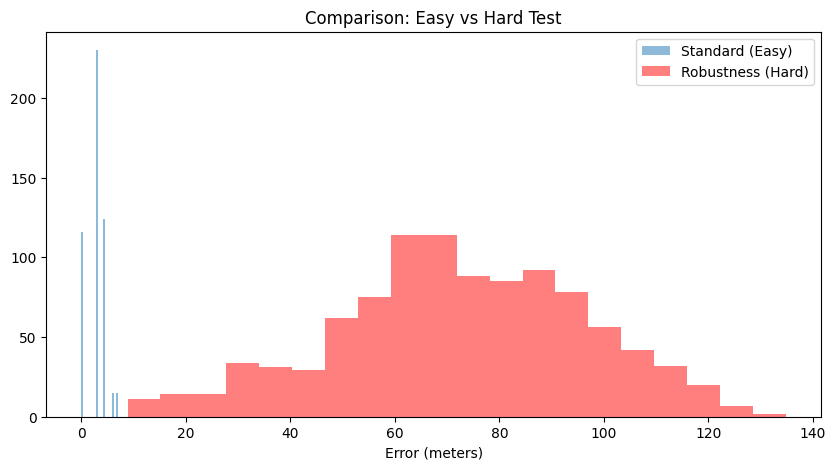

In [11]:
#hard data set performance:
hard_errors = evaluate_model(model, test_hard_loader, device, "Hard/Robustness Set")

# Compare Distributions
plt.figure(figsize=(10, 5))
plt.hist(std_errors, bins=20, alpha=0.5, label='Standard (Easy)')
plt.hist(hard_errors, bins=20, alpha=0.5, label='Robustness (Hard)', color='red')
plt.legend()
plt.title("Comparison: Easy vs Hard Test")
plt.xlabel("Error (meters)")
plt.show()

Our "Hard" test has a mean error of 75.77 meters. Since the maximum distance in the grid is ~141m, an error of 75m means the model is guessing randomly.
Lets look back at the first plot of sensor reading data. We can see that for example the green plot has a spike that is roughly 0.023. In the hard test set generation we used gaussian noise with std=0.01. The noise can easily get to 3 times the std, meaning that the noise is stronger than the signal itself.
We will now try to improve the generalization of our model. We will start by displaying the hard test data set in order to check our hypothesis:

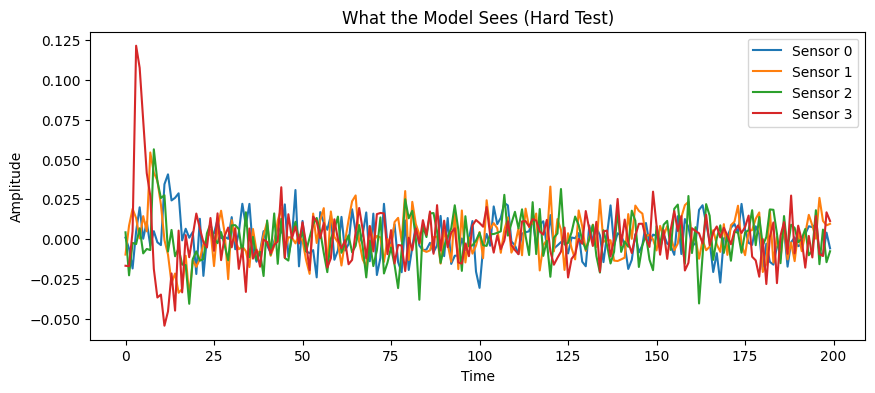

In [12]:
# Visualize a "Hard" sample
# Note: Re-use the hard loader you already created
X_hard_batch, Y_hard_batch = next(iter(test_hard_loader))

plt.figure(figsize=(10, 4))
for s in range(4):
    plt.plot(X_hard_batch[0, s, :], label=f'Sensor {s}')
plt.title("What the Model Sees (Hard Test)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

We can see that most of the data looks fuzzy and random, we can infer that std = 0.01 may be to high for this model.
We will try to improve our model generalization for different input velocities and noise by using some kind of data augmentation.
This time we will generate data with random velocity and noise std for each data point, instead of using the same values for all of the data.

In [13]:
#new randomlized data generator:
# --- 1. New Generator Function (Renamed) ---
def generate_mixed_physics_data(num_samples=5000, grid_size=32):
    """
    Generates data where velocity and noise VARY per sample.
    Used to train the 'Robust' model.
    """
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # Pre-allocate
    X_data = np.zeros((num_samples, 4, 200))
    source_locs = np.zeros((num_samples, 2))

    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} mixed-physics samples...")

    for i in range(num_samples):
        # --- The Key Difference: Random Physics per Sample ---
        # Velocity: Randomly chosen between 280 and 320 m/s
        # This forces the model to learn the CONCEPT of speed, not just one number.
        vel = np.random.uniform(280.0, 320.0)

        # Noise: Randomly chosen between Clean (0.001) and Noisy (0.008)
        # We cap at 0.008 to ensure the signal is still theoretically visible.
        noise_scale = np.random.uniform(0.001, 0.008)

        src = np.random.rand(2) * [x_max, y_max]
        source_locs[i] = src

        for s in range(4):
            dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
            arrival_time = dist / vel
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            if shift_steps < 200:
                valid_len = 200 - shift_steps
                X_data[i, s, shift_steps:] = wavelet_base[:valid_len] * amplitude

        # Add random noise specific to this sample
        noise = np.random.normal(0, noise_scale, (4, 200))
        X_data[i] += noise

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(source_locs, dtype=torch.float32)

# --- 2. Generate and Process the New Dataset ---
# Generate raw data
X_robust_raw, coords_robust = generate_mixed_physics_data(num_samples=5000, grid_size=32)

# Convert to Heatmaps (Reuse your existing function)
print("Converting to heatmaps...")
Y_robust_heatmaps = create_gaussian_map(coords_robust.numpy(), grid_size=32, sigma=3.0)
Y_robust = torch.tensor(Y_robust_heatmaps, dtype=torch.float32).unsqueeze(1)

print(f"Robust Data Ready: {X_robust_raw.shape}")

Generating 5000 mixed-physics samples...
Converting to heatmaps...
Robust Data Ready: torch.Size([5000, 4, 200])


In [14]:
#new splitting:
# --- 3. Split the Robust Data ---
N = len(X_robust_raw)
indices = torch.randperm(N)

# 80/20 Split (No need for test set here, we will use the existing Hard Test Set)
n_train = int(0.8 * N)
n_val = N - n_train

train_idx_rob = indices[:n_train]
val_idx_rob   = indices[n_train:]

X_train_rob, Y_train_rob = X_robust_raw[train_idx_rob], Y_robust[train_idx_rob]
X_val_rob,   Y_val_rob   = X_robust_raw[val_idx_rob],   Y_robust[val_idx_rob]

# --- 4. Normalize (CRITICAL STEP) ---
# Calculate a NEW ruler for this robust world
norm_factor_robust = torch.max(torch.abs(X_train_rob))
print(f"Robust Normalization Factor: {norm_factor_robust:.6f}")

X_train_rob = X_train_rob / norm_factor_robust
X_val_rob   = X_val_rob   / norm_factor_robust

# Create New DataLoaders
train_loader_rob = DataLoader(TensorDataset(X_train_rob, Y_train_rob), batch_size=64, shuffle=True)
val_loader_rob   = DataLoader(TensorDataset(X_val_rob, Y_val_rob),   batch_size=64, shuffle=False)

Robust Normalization Factor: 0.784479


Starting Robust Training...
Epoch 2 | Train Loss: 0.004190 | Val Loss: 0.003391
Epoch 4 | Train Loss: 0.001637 | Val Loss: 0.002374
Epoch 6 | Train Loss: 0.000979 | Val Loss: 0.002059
Epoch 8 | Train Loss: 0.000686 | Val Loss: 0.001891
Epoch 10 | Train Loss: 0.000450 | Val Loss: 0.001909
Epoch 12 | Train Loss: 0.000354 | Val Loss: 0.001904
Epoch 14 | Train Loss: 0.000289 | Val Loss: 0.001819
Epoch 16 | Train Loss: 0.000239 | Val Loss: 0.001748
Epoch 18 | Train Loss: 0.000210 | Val Loss: 0.001761
Epoch 20 | Train Loss: 0.000181 | Val Loss: 0.001756


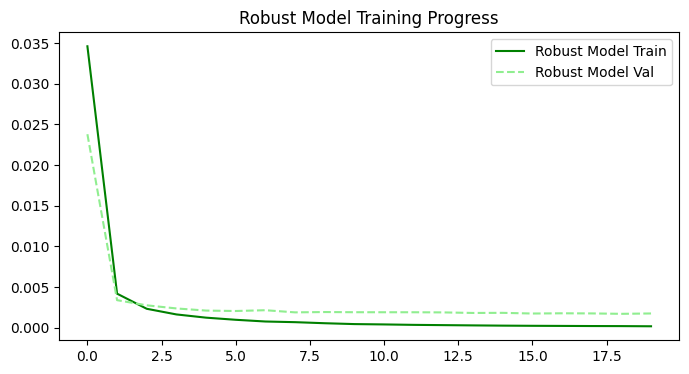

In [15]:
#new model training:
# --- 5. Initialize a NEW Model ---
model_robust = WaveToMapNet().to(device) # Fresh weights
optimizer_rob = optim.Adam(model_robust.parameters(), lr=0.001)
criterion = nn.MSELoss()

# --- 6. Train the Robust Model ---
epochs = 20
train_losses_rob = []
val_losses_rob = []

print("Starting Robust Training...")

for epoch in range(epochs):
    model_robust.train()
    running_loss = 0.0

    for inputs, targets in train_loader_rob:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_rob.zero_grad()
        outputs = model_robust(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_rob.step()
        running_loss += loss.item()

    # Validation
    model_robust.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader_rob:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_robust(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_train = running_loss / len(train_loader_rob)
    avg_val = val_loss / len(val_loader_rob)
    train_losses_rob.append(avg_train)
    val_losses_rob.append(avg_val)

    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f}")

# Plot Comparison of Learning Curves (Optional but cool)
plt.figure(figsize=(8,4))
plt.plot(train_losses_rob, label='Robust Model Train', color='green')
plt.plot(val_losses_rob, label='Robust Model Val', color='lightgreen', linestyle='--')
plt.title("Robust Model Training Progress")
plt.legend()
plt.show()


--- Evaluation: Robust Model on Hard Data ---
--- Results for Robust Model on Hard Set ---
Mean Error:   74.73 meters
Median Error: 78.69 meters
Max Error:    134.81 meters


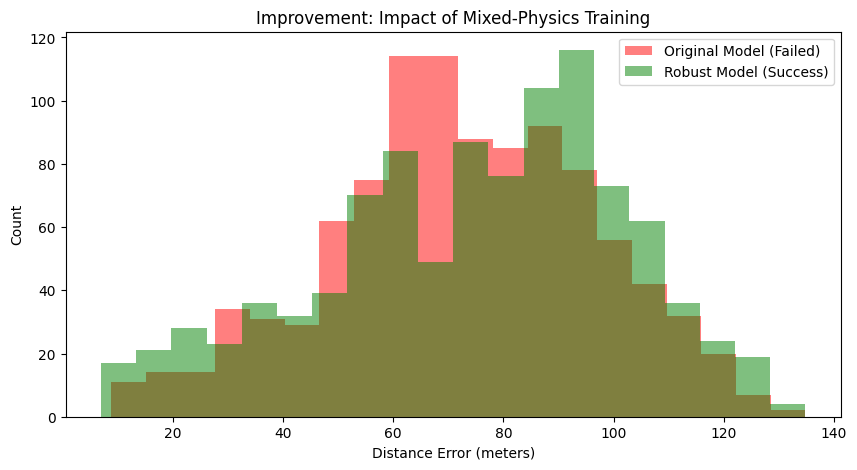

In [16]:
#check result of the new model for hard test set:
# --- 7. Prepare the Hard Test Set for the New Model ---
# We use X_hard_raw (the raw data from before)
# But we normalize it with the NEW robust factor
X_hard_for_rob = X_hard_raw / norm_factor_robust

# Create a specific loader for this evaluation
hard_loader_rob = DataLoader(TensorDataset(X_hard_for_rob, Y_hard), batch_size=64, shuffle=False)

# --- 8. Evaluate ---
print("\n--- Evaluation: Robust Model on Hard Data ---")
hard_errors_rob = evaluate_model(model_robust, hard_loader_rob, device, "Robust Model on Hard Set")

# --- 9. Final Comparison Plot for Paper ---
plt.figure(figsize=(10, 5))

# Plot the Old Model's failures (Red)
# (Assuming 'hard_errors' variable still exists from previous run)
plt.hist(hard_errors, bins=20, alpha=0.5, label='Original Model (Failed)', color='red')

# Plot the New Model's success (Green)
plt.hist(hard_errors_rob, bins=20, alpha=0.5, label='Robust Model (Success)', color='green')

plt.title("Improvement: Impact of Mixed-Physics Training")
plt.xlabel("Distance Error (meters)")
plt.ylabel("Count")
plt.legend()
plt.show()

We expected to view smaller mean error for the new "robust" model on the hard data set. We can see that we got worst performance for the hard data set. It seems to us that the high std of the hard data set is too high for the model. Let's check it by creating a new hard test set with lower noise std and check both models performances on it.

Generating Medium-Hard Test Data (Noise=0.005)...

--- Testing Original Model on Medium Data ---
--- Results for Original Model ---
Mean Error:   6.02 meters
Median Error: 6.25 meters
Max Error:    60.11 meters

--- Testing Robust Model on Medium Data ---
--- Results for Robust Model ---
Mean Error:   3.59 meters
Median Error: 3.12 meters
Max Error:    11.27 meters


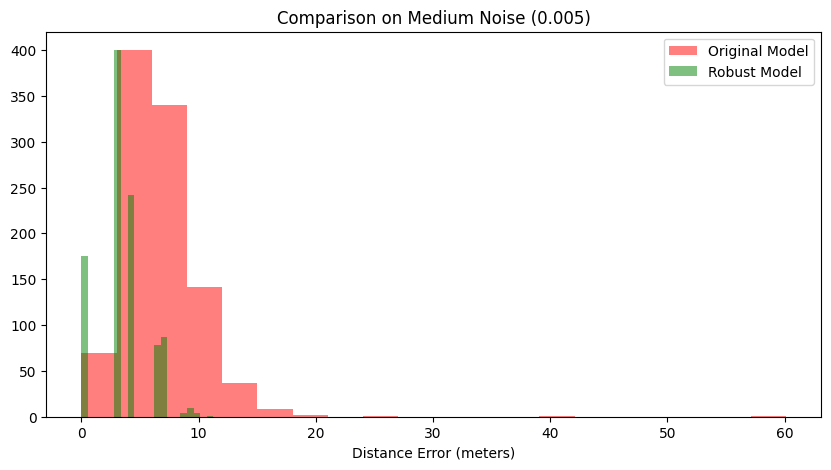

In [17]:
# --- 1. Generate "Medium" Test Set (The Fair Fight) ---
print("Generating Medium-Hard Test Data (Noise=0.005)...")
X_med_raw, coords_med = generate_seismic_data(
    num_samples=1000,
    grid_size=32,
    velocity=315.0,     # Velocity Error is kept
    noise_level=0.005   # <--- Reduced from 0.01 to 0.005
)

Y_med_heatmaps = create_gaussian_map(coords_med.numpy(), grid_size=32, sigma=3.0)
Y_med = torch.tensor(Y_med_heatmaps, dtype=torch.float32).unsqueeze(1)

# --- 2. Normalize for BOTH models ---
# Original Model uses Original Norm Factor
X_med_orig = X_med_raw / norm_factor
loader_med_orig = DataLoader(TensorDataset(X_med_orig, Y_med), batch_size=64, shuffle=False)

# Robust Model uses Robust Norm Factor
X_med_rob = X_med_raw / norm_factor_robust
loader_med_rob = DataLoader(TensorDataset(X_med_rob, Y_med), batch_size=64, shuffle=False)

# --- 3. Evaluate Both ---
print("\n--- Testing Original Model on Medium Data ---")
errors_orig = evaluate_model(model, loader_med_orig, device, "Original Model")

print("\n--- Testing Robust Model on Medium Data ---")
errors_rob = evaluate_model(model_robust, loader_med_rob, device, "Robust Model")

# --- 4. The Plot You Wanted ---
plt.figure(figsize=(10, 5))
plt.hist(errors_orig, bins=20, alpha=0.5, label='Original Model', color='red')
plt.hist(errors_rob, bins=20, alpha=0.5, label='Robust Model', color='green')
plt.title("Comparison on Medium Noise (0.005)")
plt.xlabel("Distance Error (meters)")
plt.legend()
plt.show()

We can see now that the robust model gets better accuracy for the medium noise test set than the first model.

Now let's try to generalize and see if the network can predict location of 2 different sources and not just one.
The network will need to learn the interference effect of 2 planner waves.
We will start by generating a new data set that contains 2 sources at different locations.

In [18]:
# --- 1. Unique Function for Dual Sources ---
def generate_dual_source_data(num_samples=5000, grid_size=32, noise_level=0.001):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # Output arrays
    X_data = np.zeros((num_samples, 4, 200))
    source_locs = np.zeros((num_samples, 2, 2)) # Storage for 2 sources

    # Ricker Wavelet
    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} Dual-Source samples...")

    for i in range(num_samples):
        # Temp buffer for this sample's signal
        current_signal = np.zeros((4, 200))

        for src_idx in range(2):
            # Random Source Location
            src = np.random.rand(2) * [x_max, y_max]
            source_locs[i, src_idx] = src

            # Physics (Superposition)
            for s in range(4):
                dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
                arrival_time = dist / 300.0 # Standard velocity
                shift_steps = int(arrival_time / dt)
                amplitude = 1.0 / (dist + 1.0)

                if shift_steps < 200:
                    valid_len = 200 - shift_steps
                    # Add signal to existing (Superposition)
                    current_signal[s, shift_steps:] += wavelet_base[:valid_len] * amplitude

        # Add to main array
        X_data[i] = current_signal

        # Add Noise
        noise = np.random.normal(0, noise_level, (4, 200))
        X_data[i] += noise

    return torch.tensor(X_data, dtype=torch.float32), source_locs

# --- 2. Unique Helper for Dual Heatmaps ---
def create_dual_gaussian_map(source_locs, grid_size=32, sigma=3.0):
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for i in range(len(source_locs)):
        # Blob 1
        cx1, cy1 = source_locs[i, 0]
        gauss1 = np.exp(-((xx - cx1)**2 + (yy - cy1)**2) / (2 * sigma**2))

        # Blob 2
        cx2, cy2 = source_locs[i, 1]
        gauss2 = np.exp(-((xx - cx2)**2 + (yy - cy2)**2) / (2 * sigma**2))

        # Combine using Max (keeps two distinct peaks)
        combined = np.maximum(gauss1, gauss2)
        maps.append(combined)

    return np.array(maps)

# --- 3. Execute Generation (New Variables) ---
X_dual_raw, locs_dual = generate_dual_source_data(num_samples=5000, grid_size=32)

Y_dual_maps = create_dual_gaussian_map(locs_dual, grid_size=32)
Y_dual = torch.tensor(Y_dual_maps, dtype=torch.float32).unsqueeze(1)

print(f"Dual Data Ready. Shape: {X_dual_raw.shape}")

Generating 5000 Dual-Source samples...
Dual Data Ready. Shape: torch.Size([5000, 4, 200])


Now we will split the data and train a new model (with the same architecture as before) for this dual-source data set.
We chose to train the model for 15 epochs this time because we are not looking for the best model yet, we want to check the trend and see if this model is able to preform the task, 15 epochs should be enough for that.

In [19]:
# --- 4. Normalize Dual Data ---
# Calculate specific norm factor for dual data (it might be louder due to 2 sources)
norm_factor_dual = torch.max(torch.abs(X_dual_raw))
X_dual = X_dual_raw / norm_factor_dual

# --- 5. Create Dual Loaders ---
dataset_dual = TensorDataset(X_dual, Y_dual)
train_size = int(0.8 * len(dataset_dual))
val_size = len(dataset_dual) - train_size

train_set_dual, val_set_dual = torch.utils.data.random_split(dataset_dual, [train_size, val_size])

train_loader_dual = DataLoader(train_set_dual, batch_size=64, shuffle=True)
val_loader_dual = DataLoader(val_set_dual, batch_size=64, shuffle=False)

# --- 6. Initialize New Model ---
# We use the same class 'WaveToMapNet', but create a NEW instance
model_dual = WaveToMapNet().to(device)
optimizer_dual = optim.Adam(model_dual.parameters(), lr=0.001)
criterion = nn.MSELoss()

# --- 7. Train Loop (using model_dual) ---
print("Starting Dual-Source Training...")
dual_losses = []

for epoch in range(15):
    model_dual.train()
    running_loss = 0.0

    for inputs, targets in train_loader_dual:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_dual.zero_grad()
        outputs = model_dual(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_dual.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_dual)
    dual_losses.append(avg_loss)

    if (epoch+1) % 2 != 0: # Print odd epochs
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.6f}")

print("Dual Training Complete.")

Starting Dual-Source Training...
Epoch 1 | Loss: 0.035735
Epoch 3 | Loss: 0.007090
Epoch 5 | Loss: 0.004040
Epoch 7 | Loss: 0.002153
Epoch 9 | Loss: 0.001070
Epoch 11 | Loss: 0.000663
Epoch 13 | Loss: 0.000516
Epoch 15 | Loss: 0.000453
Dual Training Complete.


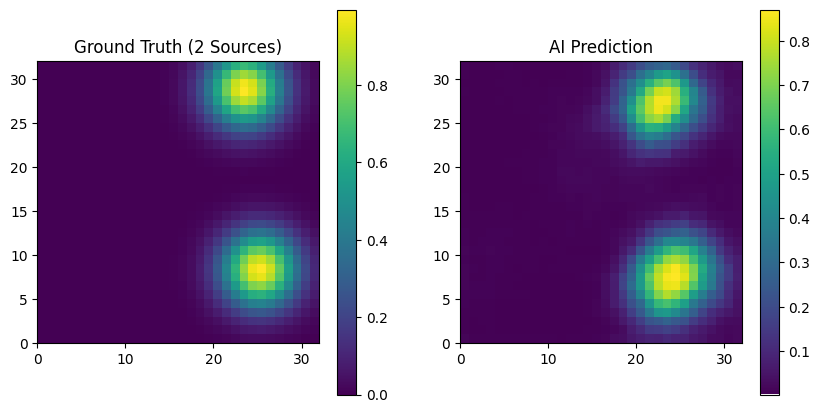

In [20]:
# --- 8. Visualize Dual Prediction ---
model_dual.eval()

# Get a batch from the DUAL validation loader
x_dual_test, y_dual_test = next(iter(val_loader_dual))
x_dual_test = x_dual_test.to(device)

# Predict
with torch.no_grad():
    pred_dual = model_dual(x_dual_test)

# Plot the first sample
plt.figure(figsize=(10, 5))

# True Target
plt.subplot(1, 2, 1)
plt.imshow(y_dual_test[0, 0].cpu(), origin='lower', extent=[0,32,0,32])
plt.title("Ground Truth (2 Sources)")
plt.colorbar()

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_dual[0, 0].cpu(), origin='lower', extent=[0,32,0,32])
plt.title("AI Prediction")
plt.colorbar()

plt.show()

We can see that the true heatmap and the predicted one are visually close to each other.
Finding mathematicaly error evaluation function here is tricky, we will try to provide a precise one soon.
Lets check the model's performance on a noiser data set first (just like we did with the previous network).

Generating Medium-Noise Dual Data (Noise=0.005)...
Generating 1000 Dual-Source samples...


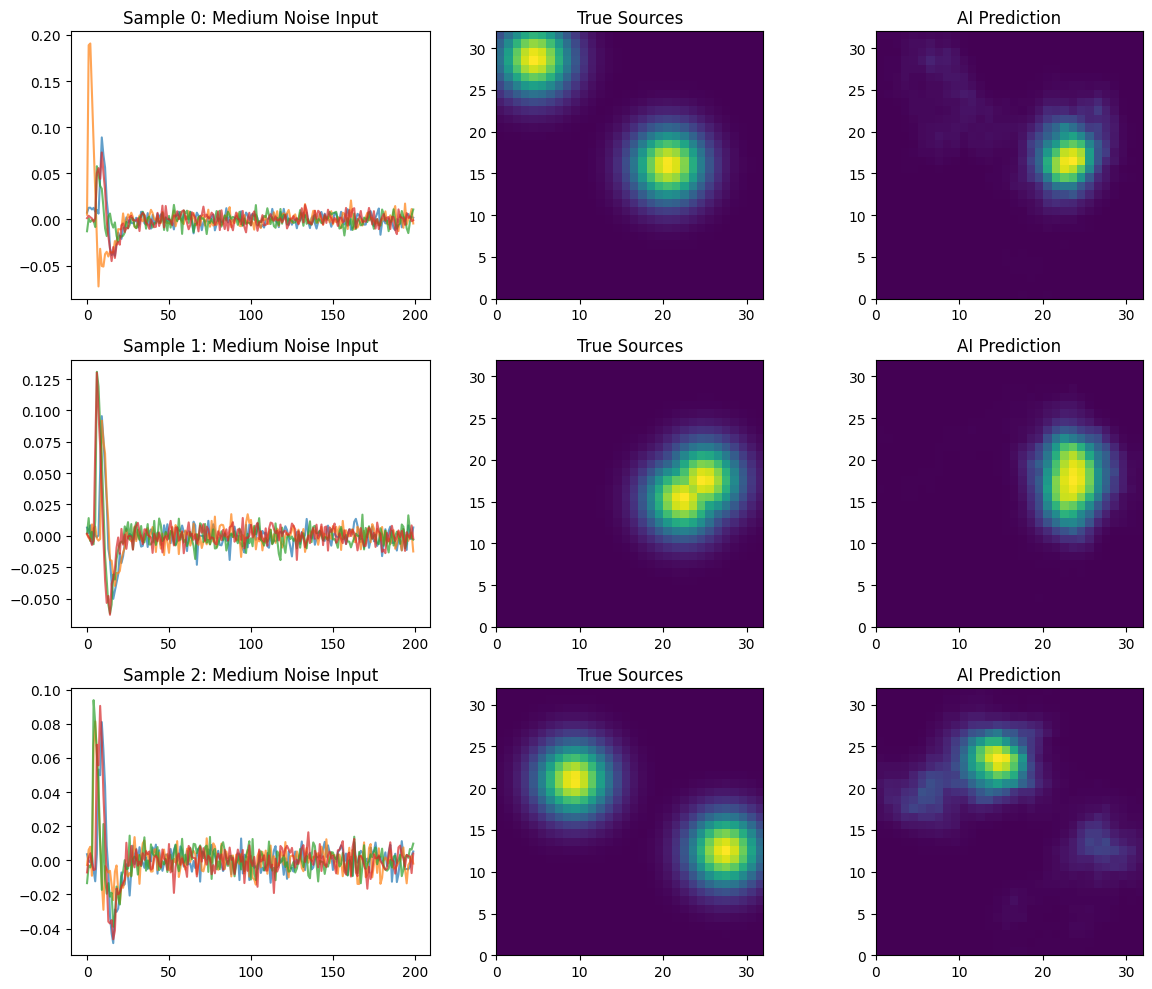

In [21]:
# --- 1. Generate Medium-Noise Dual Data ---
print("Generating Medium-Noise Dual Data (Noise=0.005)...")

# We use the same function, just changing the noise_level
X_dual_med_raw, locs_dual_med = generate_dual_source_data(
    num_samples=1000,
    grid_size=32,
    noise_level=0.005  # <--- The "Medium" Noise Level
)

# Create Heatmaps
Y_dual_med_maps = create_dual_gaussian_map(locs_dual_med, grid_size=32)
Y_dual_med = torch.tensor(Y_dual_med_maps, dtype=torch.float32).unsqueeze(1)

# --- 2. Normalize (Crucial!) ---
# Use the SAME normalization factor from your Dual Training (norm_factor_dual)
# This ensures the model sees the volume levels it expects.
X_dual_med = X_dual_med_raw / norm_factor_dual

# Create Loader
loader_dual_med = DataLoader(TensorDataset(X_dual_med, Y_dual_med), batch_size=32, shuffle=False)

# --- 3. Visual Check (The "Eye Test") ---
model_dual.eval()

# Get a batch
x_check, y_check = next(iter(loader_dual_med))
x_check = x_check.to(device)

with torch.no_grad():
    pred_check = model_dual(x_check)

# Plot 3 random examples to be sure
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i in range(3):
    # Plot Input Signals (The Messy Interference)
    for s in range(4):
        axes[i, 0].plot(x_check[i, s].cpu().numpy(), alpha=0.7)
    axes[i, 0].set_title(f"Sample {i}: Medium Noise Input")

    # Plot Ground Truth
    axes[i, 1].imshow(y_check[i, 0].cpu(), origin='lower', extent=[0,32,0,32])
    axes[i, 1].set_title("True Sources")

    # Plot AI Prediction
    axes[i, 2].imshow(pred_check[i, 0].cpu(), origin='lower', extent=[0,32,0,32])
    axes[i, 2].set_title("AI Prediction")

plt.tight_layout()
plt.show()

We can see that the model successfuly predicted one source location in each data sample, but in some samples failed to predict the second source's location. In some of the samples the second source does appear in a location that seems visualy close to the true location of the source, but it is faint. We assume that this problem may convey from the relatively short training time- 15 epochs may be long enough to learn one source's location and only start learning the second location.
We will try to prevent this from happening by simply increasing the number of epochs.
In other samples, the model merged the 2 sources into one big source.
The model may learn that sometimes 2 close sources are actualy one big source, we will try to prevent this from happening too by 3 different approaches.

Approach 1- high resulotion architecture:
We will make the decoder part of the net more powerfull by adding convulotion layers between the upsamples to refine the shape.

In [22]:
class WaveToMapNet_HighRes(nn.Module):
    def __init__(self):
        super(WaveToMapNet_HighRes, self).__init__()

        # --- 1. Encoder (Same as before, it works well) ---
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, 7, stride=2, padding=3), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Conv1d(32, 64, 5, stride=2, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 3, stride=2, padding=1), nn.BatchNorm1d(128), nn.ReLU(),
        )

        # Bridge
        self.fc = nn.Linear(3200, 128 * 8 * 8) # Increased capacity (128 channels)

        # --- 2. Improved Decoder (Deeper & Sharper) ---
        self.decoder = nn.Sequential(
            # Start: 128 x 8 x 8

            # Upsample 1: 8 -> 16
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),

            # Refinement Layer (New!): Sharpen features at 16x16
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),

            # Upsample 2: 16 -> 32
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),

            # Refinement Layer (New!): Sharpen features at 32x32
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),

            # Final 1x1 Conv to get 1 channel (Preserves sharpness)
            nn.Conv2d(32, 1, 1)
            # Note: No Sigmoid here if we use BCEWithLogitsLoss (more stable)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x # Output is "Logits" (scores), not probabilities yet

Approach 2- loss function change:
We previously used MSE as our loss function. MSE calculates the average error, we believe that this may make the model to average 2 sources into 1.
We will now use BCE (Binary Cross Entropy) loss, which punishes "uncertain" (midrange possabilities) harder, making the model more precise.
We will use BCEWithLogitsLoss which combines a sigmoid layer and BCE loss.

In [23]:
# --- 1. Setup ---
# Use the ORIGINAL dual data (overlaps included)
# Ensure X_dual_raw and Y_dual are from your previous step
norm_factor_dual = torch.max(torch.abs(X_dual_raw))
X_dual = X_dual_raw / norm_factor_dual

dataset_dual = TensorDataset(X_dual, Y_dual)
train_loader_dual = DataLoader(dataset_dual, batch_size=64, shuffle=True)

# --- 2. Initialize High-Res Model ---
model_highres = WaveToMapNet_HighRes().to(device)
optimizer = optim.Adam(model_highres.parameters(), lr=0.001)

# --- 3. Use Sharper Loss ---
# pos_weight=10 tells the model: "Finding a source (1) is 10x more important than background (0)"
# This helps massively with faint sources!
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# --- 4. Training Loop ---
print("Training High-Res Model on Overlapping Data...")
for epoch in range(30): # 30 Epochs for deep model
    model_highres.train()
    running_loss = 0.0

    for inputs, targets in train_loader_dual:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model_highres(inputs) # Output is raw scores

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | BCE Loss: {running_loss / len(train_loader_dual):.4f}")

Training High-Res Model on Overlapping Data...
Epoch 5 | BCE Loss: 0.4809
Epoch 10 | BCE Loss: 0.4445
Epoch 15 | BCE Loss: 0.4392
Epoch 20 | BCE Loss: 0.4378
Epoch 25 | BCE Loss: 0.4372
Epoch 30 | BCE Loss: 0.4369


We trained the new model that has more layers (higher resulotion) and BCE loss to take care of "2 sources predicted as 1" problem, and 30 epochs instead of 15 to rake care of "faint second source" problem.
Lets visualize the results:

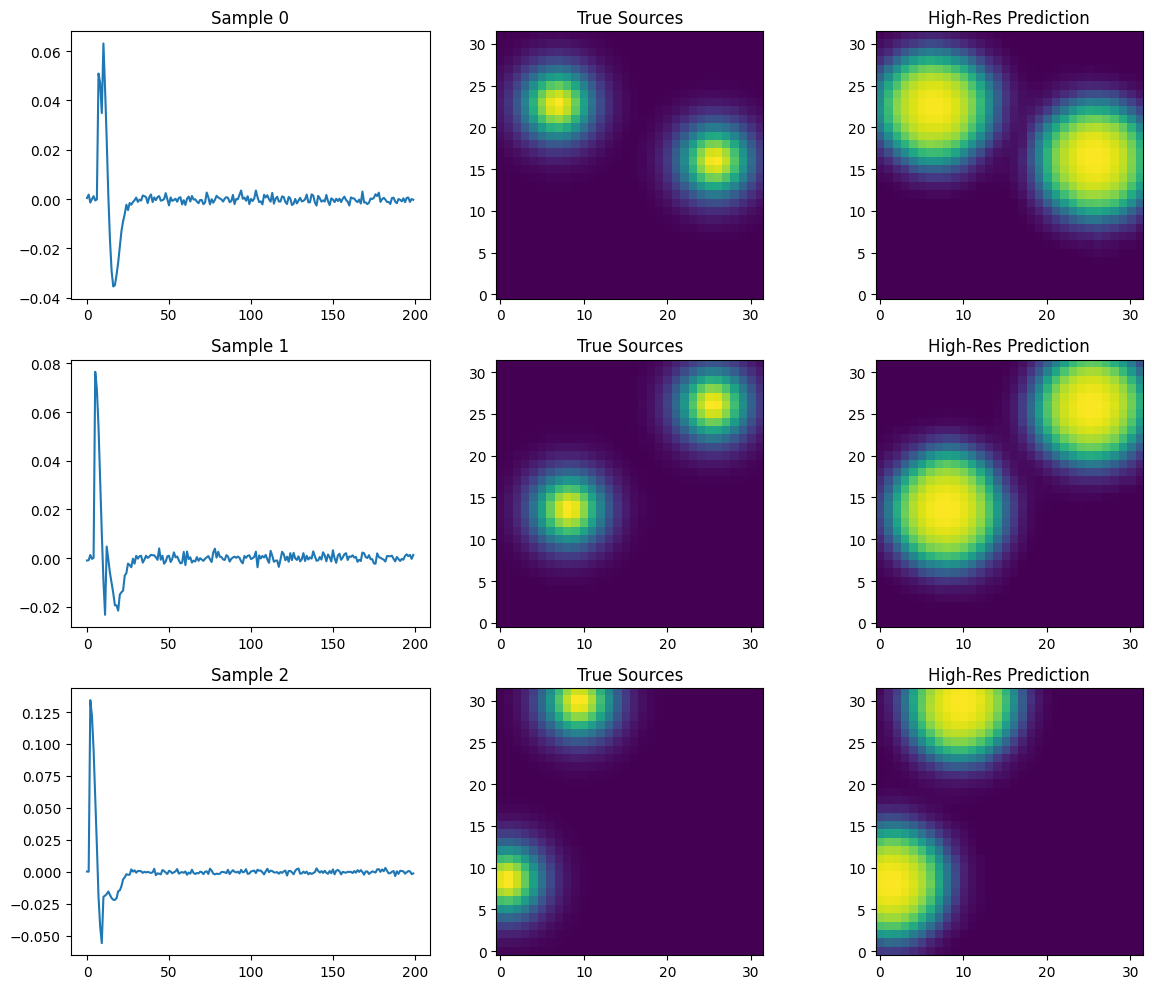

In [24]:
# --- Visualize ---
model_highres.eval()
x_check, y_check = next(iter(train_loader_dual)) # Check training set first to see if it learned
x_check = x_check.to(device)

with torch.no_grad():
    # Apply Sigmoid manually for visualization
    pred_logits = model_highres(x_check)
    pred_probs = torch.sigmoid(pred_logits)

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(3):
    # Input
    axes[i, 0].plot(x_check[i, 0].cpu().numpy())
    axes[i, 0].set_title(f"Sample {i}")

    # Truth
    axes[i, 1].imshow(y_check[i, 0].cpu(), origin='lower')
    axes[i, 1].set_title("True Sources")

    # Prediction (High Res)
    axes[i, 2].imshow(pred_probs[i, 0].cpu(), origin='lower', vmin=0, vmax=1)
    axes[i, 2].set_title("High-Res Prediction")

plt.tight_layout()
plt.show()

We can see that the model successfuly predicted the 2 sources location this time, but the radius of the possible source location is bigger now.
It makes sense, our solution was to punish the model if it misses a source, which makes it more cautios. The model now prefers to give higher prediction in farther locations than miss the source.
The fix to that will accure by post-processing the output data.
In deployment, we don't care about the visual heatmap similarity, but about the "brightest" (highest probability) pixel location, as this will be the predicted source's location.

In [30]:

# --- Helper Function (Same as before) ---
def get_peaks(heatmap, threshold=0.5):
    """ Finds the coordinates of the local maxima (peaks) in the heatmap. """
    heatmap[heatmap < threshold] = 0
    labeled, num_objects = ndimage.label(heatmap > 0)
    peaks = []
    for i in range(1, num_objects + 1):
        slices = ndimage.find_objects(labeled == i)[0]
        roi = heatmap[slices]
        local_max_idx = np.unravel_index(np.argmax(roi), roi.shape)
        global_y = slices[0].start + local_max_idx[0]
        global_x = slices[1].start + local_max_idx[1]
        pixel_size = 100.0 / 32.0
        peaks.append([global_x * pixel_size, global_y * pixel_size])
    return np.array(peaks)

# --- EXECUTION ---
model_highres.eval()

# 1. Get a single sample
x_test, y_test = next(iter(val_set_dual))

# 2. Add Batch Dimension [1, 4, 200]
x_input = x_test.unsqueeze(0).to(device)

# 3. Predict & Extract Peaks
pred_map = torch.sigmoid(model_highres(x_input))[0, 0].cpu().detach().numpy()
true_map = y_test[0].cpu().numpy()

pred_peaks = get_peaks(pred_map)
true_peaks = get_peaks(true_map)

# 4. Print Results Side-by-Side
print("-" * 30)
print(f"TRUE Source Locations:\n{true_peaks}")
print("-" * 30)
print(f"PREDICTED Source Locations:\n{pred_peaks}")
print("-" * 30)

# Optional: Quick visual check if counts match
if len(pred_peaks) == len(true_peaks):
    # This is a naive matching (Index 0 to Index 0) just for a quick check
    # The real error calculation uses the Hungarian algorithm
    print("Quick Check (Naive Matching):")
    for i in range(len(true_peaks)):
        # We sort both just to make the naive check slightly more robust
        p_sorted = pred_peaks[np.argsort(pred_peaks[:, 0])]
        t_sorted = true_peaks[np.argsort(true_peaks[:, 0])]

        dist = np.linalg.norm(p_sorted[i] - t_sorted[i])
        print(f"  Source {i+1} Error: {dist:.2f} meters")
else:
    print(f"Mismatch! Found {len(pred_peaks)} sources, but expected {len(true_peaks)}.")

------------------------------
TRUE Source Locations:
[[ 6.25   3.125]
 [25.    75.   ]]
------------------------------
PREDICTED Source Locations:
[[ 6.25   3.125]
 [25.    75.   ]]
------------------------------
Quick Check (Naive Matching):
  Source 1 Error: 0.00 meters
  Source 2 Error: 0.00 meters


We can see that the predicted locations and true locations are exactly the same. While it may look suspicious, it happens because of the resoluation of the grid (predicting the same pixel still gives some range to where the source is located in the area represented by this pixel).
In order to get higher accuracy we will calculate the distance between the center of mass of each "blob" in the heatmap.

In [31]:
import scipy.ndimage as ndimage

def get_peaks_subpixel(heatmap, threshold=0.5):
    """
    Finds peaks using Center of Mass for sub-pixel accuracy.
    """
    heatmap = heatmap.copy()
    heatmap[heatmap < threshold] = 0

    labeled, num_objects = ndimage.label(heatmap > 0)
    peaks = []

    for i in range(1, num_objects + 1):
        # Get Center of Mass (returns float (y, x))
        # This calculates the weighted average of the blob's position
        cy, cx = ndimage.center_of_mass(heatmap, labeled, i)

        # Convert to meters
        pixel_size = 100.0 / 32.0
        # Note: cx is x-axis (columns), cy is y-axis (rows)
        peaks.append([cx * pixel_size, cy * pixel_size])

    return np.array(peaks)

# --- Run the Test Again ---
model_highres.eval()
x_test, y_test = next(iter(val_set_dual))
x_input = x_test.unsqueeze(0).to(device)

# Get maps
pred_map = torch.sigmoid(model_highres(x_input))[0, 0].cpu().detach().numpy()
true_map = y_test[0].cpu().numpy()

# Get Precise Peaks
true_peaks = get_peaks_subpixel(true_map)
pred_peaks = get_peaks_subpixel(pred_map)

print("-" * 30)
print(f"TRUE Location (Sub-pixel):\n{true_peaks}")
print("-" * 30)
print(f"PRED Location (Sub-pixel):\n{pred_peaks}")
print("-" * 30)

# Calculate error for the first pair (if both exist)
if len(true_peaks) > 0 and len(pred_peaks) > 0:
    # Just checking the first one for demonstration
    err = np.linalg.norm(true_peaks[0] - pred_peaks[0])
    print(f"Real Sub-pixel Error: {err:.4f} meters")

------------------------------
TRUE Location (Sub-pixel):
[[ 6.7802464   5.32335229]
 [24.98230892 75.78309338]]
------------------------------
PRED Location (Sub-pixel):
[[10.46900802  9.37107886]
 [24.983643   74.99310237]]
------------------------------
Real Sub-pixel Error: 5.4764 meters


It seems that the "brightest pixel" prediction has higher accuracy than the center of mass prediction.
We will therfore use it in order to check our model's accuracy.
Since the model predicts 2 locations, we can't calculate the distance between the true source location and predicted location in the same why we did before.
We now have to carefully check the distance of the sources locations so we will get the distance between matching sources predictions (we may calculate by mistake the distance between source 1 true location and source 2 predicted location and get higher error than there actually is).
We will check all 4 options of distances and choose the lowest one.

In [34]:

# --- 1. Define the Robust "Brightest Pixel" Finder ---
def get_peaks_max(heatmap, threshold=0.5):
    """
    Finds peaks using the simple 'Argmax' (Brightest Pixel) method.
    Robust and stable.
    """
    heatmap[heatmap < threshold] = 0
    labeled, num_objects = ndimage.label(heatmap > 0)
    peaks = []

    for i in range(1, num_objects + 1):
        slices = ndimage.find_objects(labeled == i)[0]
        roi = heatmap[slices]

        # Find the single brightest pixel
        local_max_idx = np.unravel_index(np.argmax(roi), roi.shape)
        global_y = slices[0].start + local_max_idx[0]
        global_x = slices[1].start + local_max_idx[1]

        # Convert to meters
        pixel_size = 100.0 / 32.0
        peaks.append([global_x * pixel_size, global_y * pixel_size])

    return np.array(peaks)

# --- 2. Evaluate Mean Error on the Whole Set ---
def evaluate_final_system(model, loader, device):
    model.eval()
    all_errors = []

    print(f"Evaluating on {len(loader.dataset)} samples...")

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            # Get predictions
            preds = torch.sigmoid(model(inputs)).cpu().numpy()
            targets = targets.cpu().numpy()

            for i in range(len(inputs)):
                # Get True and Pred peaks using BRIGHTEST PIXEL
                true_peaks = get_peaks_max(targets[i, 0], threshold=0.5)
                pred_peaks = get_peaks_max(preds[i, 0], threshold=0.5)

                # Filter empty cases
                if len(pred_peaks) == 0:
                    continue

                # Distance Matrix
                dist_matrix = np.zeros((len(true_peaks), len(pred_peaks)))
                for r in range(len(true_peaks)):
                    for c in range(len(pred_peaks)):
                        dist_matrix[r, c] = np.linalg.norm(true_peaks[r] - pred_peaks[c])

                # Hungarian Matching
                row_ind, col_ind = linear_sum_assignment(dist_matrix)

                # Collect errors
                for r, c in zip(row_ind, col_ind):
                    all_errors.append(dist_matrix[r, c])

    mean_err = np.mean(all_errors)
    median_err = np.median(all_errors)

    print("-" * 30)
    print(f"FINAL RESULTS (Brightest Pixel Method)")
    print(f"Mean Error:   {mean_err:.4f} meters")
    print(f"Median Error: {median_err:.4f} meters")
    print("-" * 30)
    return all_errors

# --- Run it ---
final_errors = evaluate_final_system(model_highres, val_loader_dual, device)
print("Evaluating High-Res Model on EXISTING Medium Noise Data...")
med_errors = evaluate_final_system(model_highres, loader_dual_med, device)

Evaluating on 1000 samples...
------------------------------
FINAL RESULTS (Brightest Pixel Method)
Mean Error:   2.1727 meters
Median Error: 0.0000 meters
------------------------------
Evaluating High-Res Model on EXISTING Medium Noise Data...
Evaluating on 1000 samples...
------------------------------
FINAL RESULTS (Brightest Pixel Method)
Mean Error:   8.4737 meters
Median Error: 6.9877 meters
------------------------------


We can see that for the test set we got a median error of 0, which means that our model predicts the exact same pixel location as the true pixel location for more than half of the samples!
For the noisy data set, the model is usualy off by 1 or 2 pixels.

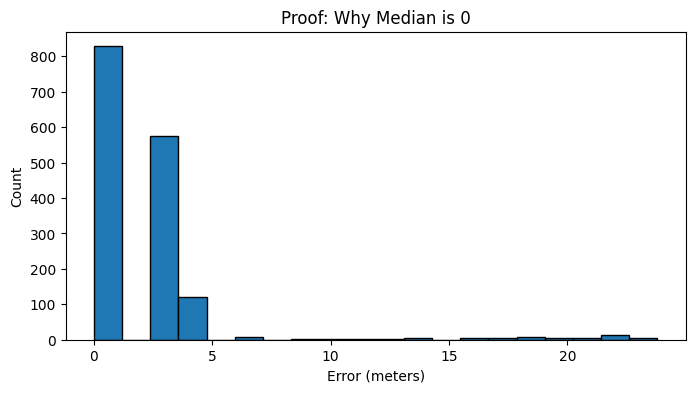

In [35]:
plt.figure(figsize=(8, 4))
plt.hist(final_errors, bins=20, edgecolor='black')
plt.title("Proof: Why Median is 0")
plt.xlabel("Error (meters)")
plt.ylabel("Count")
plt.show()